In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import json
import scipy.stats as sps

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

from enterprise_extensions import models, hypermodel
from enterprise_extensions.model_utils import bayes_fac
from la_forge import core, diagnostics

#from settings import fd_bins

Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
import sys
sys.path.insert(0,'/content/12p5yr_stochastic_analysis/tutorials')

In [3]:
parfiles = '/Users/aidenagostinelli/12p5yr_stochastic_analysis/tutorials/data/par/J2010-1323_NANOGrav_12yv3.gls.par'
timfiles = '/Users/aidenagostinelli/12p5yr_stochastic_analysis/tutorials/data/tim/J2010-1323_NANOGrav_12yv3.tim'
print(parfiles)
print(timfiles)

/Users/aidenagostinelli/12p5yr_stochastic_analysis/tutorials/data/par/J2010-1323_NANOGrav_12yv3.gls.par
/Users/aidenagostinelli/12p5yr_stochastic_analysis/tutorials/data/tim/J2010-1323_NANOGrav_12yv3.tim


In [4]:
ephemeris = 'DE438'
psr = [Pulsar(parfiles, timfiles, ephem=ephemeris)]

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. ../par/J2010-1323_NANOGrav_12yv3.gls.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[observatory.C:272] Warning: Assuming site '1' means 'gbt'


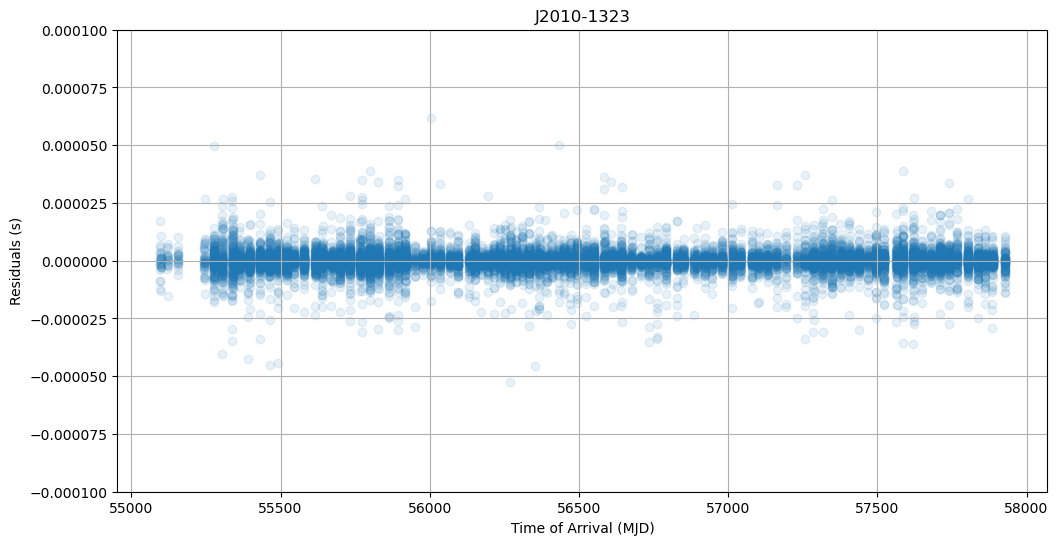

In [5]:
plt.figure(figsize=(12, 6))
plt.scatter(psr[0].toas / 86400, psr[0].residuals, alpha=0.1)
plt.title(psr[0].name)
plt.xlabel('Time of Arrival (MJD)')
plt.ylabel('Residuals (s)')
plt.ylim([-1e-4, 1e-4])
plt.grid(visible=True)
plt.show()

In [6]:
noise_ng12 = '/Users/aidenagostinelli/12p5yr_stochastic_analysis/tutorials/data/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [7]:
selection = selections.Selection(selections.by_backend)

In [8]:
pta = models.model_2a(psr,
                      psd='powerlaw',
                      noisedict=params,
                      n_gwbfreqs=5,  # modify the number of common red noise frequencies here
                      gamma_common=13/3,  # remove this line for a varying spectral index
                      tnequad=True,  # required when using old white noise equad calculation
                      tm_marg=True,  # use MarginalizingTimingModel
                      tm_svd=True  # SVD on timing model
                    )

Package `fastshermanmorrison` not installed. Fallback to sherman-morrison


In [9]:
super_model = hypermodel.HyperModel({0: pta})

In [10]:
outDir = './chains/sngl_gwb_1713'
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



In [21]:
N = int(3e5)
x0 = super_model.initial_sample()
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 3.33 percent in 5.031984 s Acceptance rate = 0.794578Adding DE jump with weight 50
Finished 100.00 percent in 132.707296 s Acceptance rate = 0.648913
Run Complete


In [22]:
c1 = core.Core(chaindir='./chains/sngl_gwb_1713')

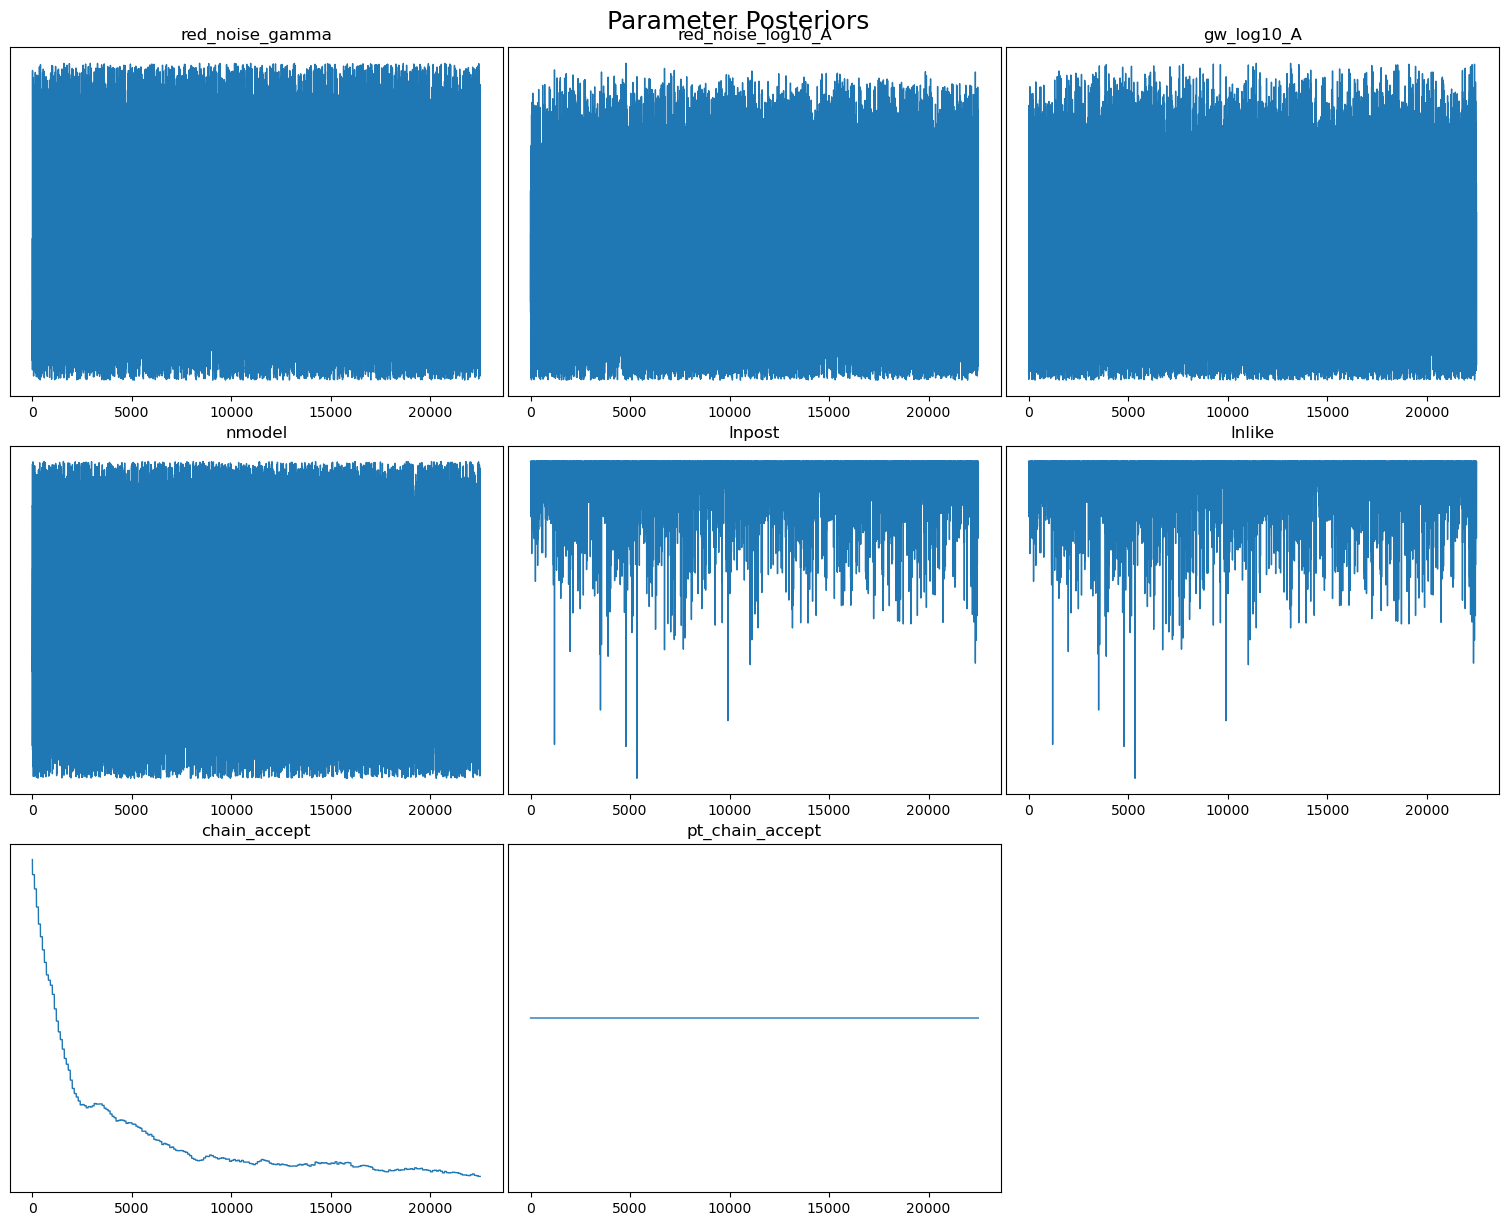

<Figure size 640x480 with 0 Axes>

In [23]:
diagnostics.plot_chains(c1, hist=False)
plt.savefig('trace_4')

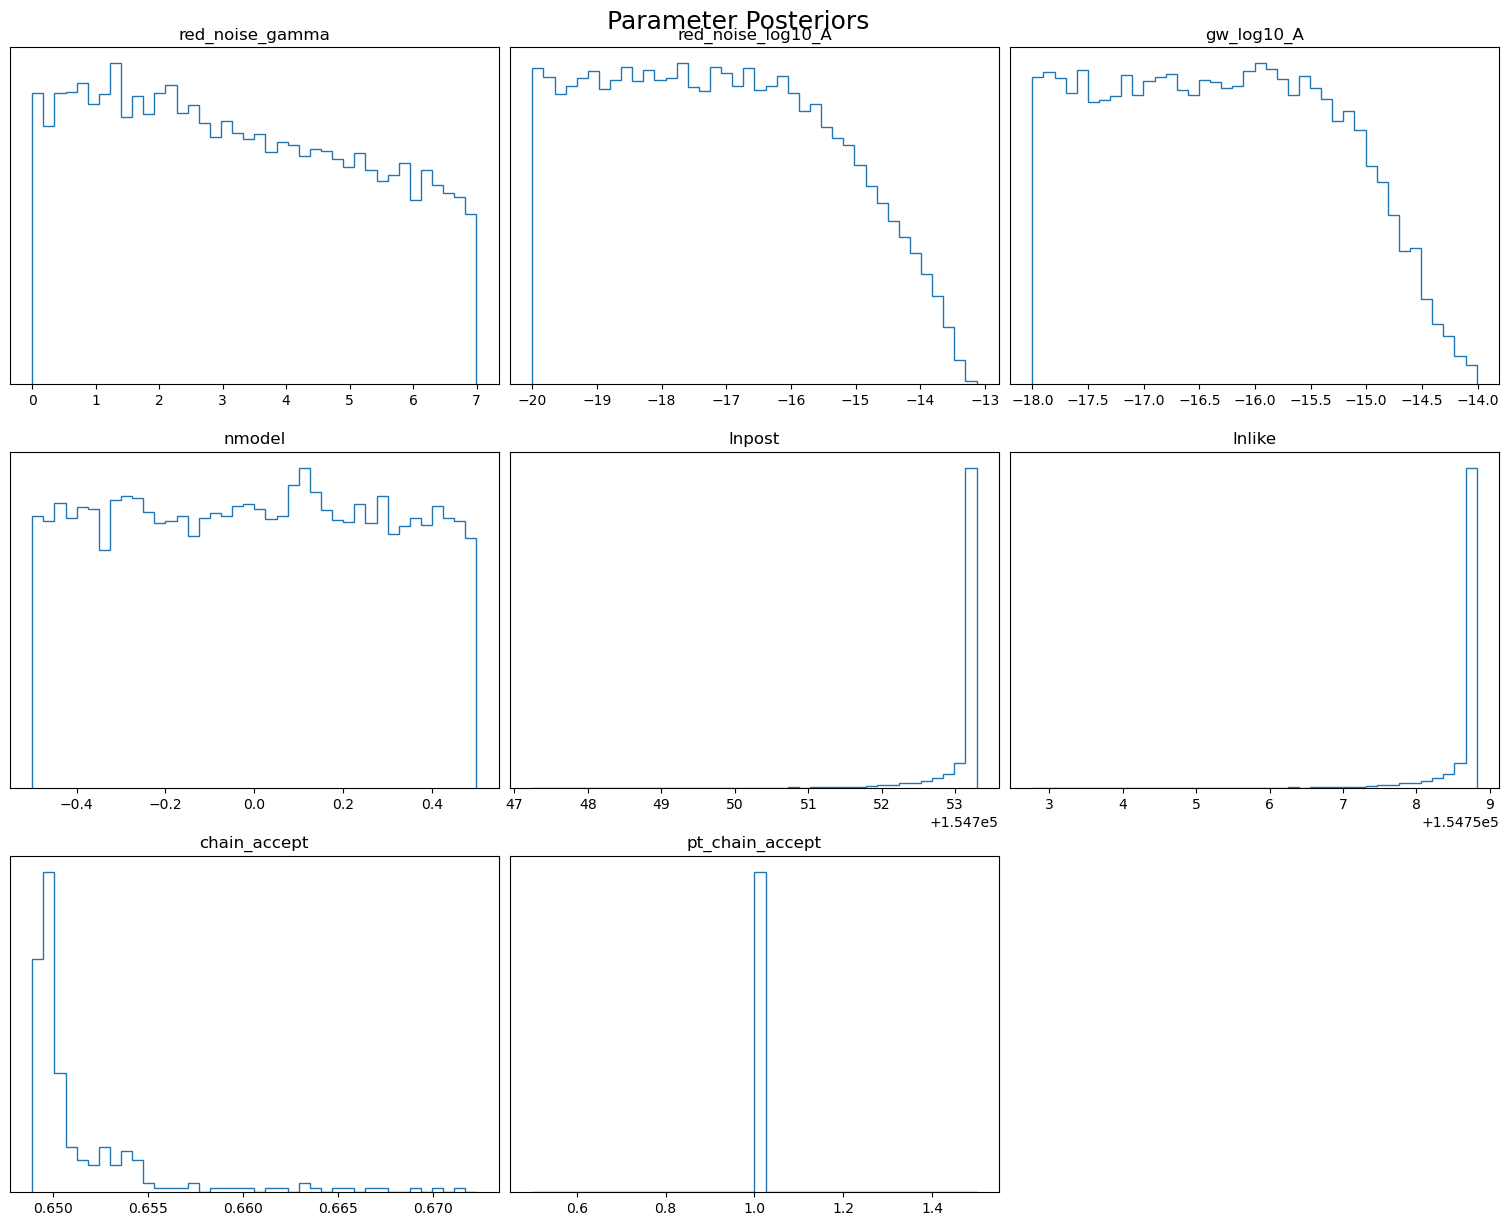

<Figure size 640x480 with 0 Axes>

In [24]:
diagnostics.plot_chains(c1)
plt.savefig('post_4')

In [25]:
bf = bayes_fac(c1.get_param('gw_log10_A')[c1.burn:], ntol=0, logAmin=-18, logAmax=-12)
print(bf)

(0.5046895546825135, 0.032439237081570114)
